# Tutorial CNN: Fairneuron

### By Maud Groen, Matthieu Janssen & Jeroen Wasser

In [5]:
import argparse
import time
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch
from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import dataset
from torch.utils.data.dataset import random_split

## Initial set-up

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128
epoch = 50
file_name='{}_epoch{}_{}'.format(dataset,epoch,int(time.time()))
df = pd.read_csv('compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv')

## Preparing the data

In [9]:
def transform_dataset(df):
    """

    :param df:
    :return: Tuple of the transformed dataset and the labels Y and S
    """

    df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]

    del df_binary['c_jail_in']
    del df_binary['c_jail_out']

    ##separated class from the rests of the features
    # remove unnecessary dimensions from Y -> only the decile_score remains
    Y = df_binary['decile_score']
    del df_binary['decile_score']
    Y_true = df_binary['two_year_recid']
    del df_binary['two_year_recid']
    del df_binary['score_text']

    S = df_binary['race']

    # set sparse to False to return dense matrix after transformation and keep all dimensions homogeneous
    encod = preprocessing.OneHotEncoder(sparse=False)

    data_to_encode = df_binary.to_numpy()
    feat_to_encode = data_to_encode[:, 0]
    # transposition
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.DataFrame(encoded_feature)

    feat_to_encode = data_to_encode[:, 1]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)


    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 2] == "Caucasian"
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    for i in range(3, 10):
        encoded_feature = data_to_encode[:, i]
        ma = np.amax(encoded_feature)
        mi = np.amin(encoded_feature)
        encoded_feature = (encoded_feature - mi) / (ma - mi)
        df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 10]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 11]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    return df_binary_encoded, Y, S, Y_true

In [10]:
class DataClass():
    def __init__(self,df) -> None:

        df_binary, Y, S, Y_true = transform_dataset(df)
        Y = Y.to_numpy()    
        self.l_tensor = torch.tensor(Y_true.to_numpy().reshape(-1, 1).astype(np.float32))
        self.threshold=4
        self.x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
        self.y_tensor = torch.tensor(Y.reshape(-1, 1).astype(np.float32))
        self.s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())
        self.dataset = TensorDataset(self.x_tensor, self.y_tensor, self.l_tensor, self.s_tensor)
        base_size = len(self.dataset) // 10
        split = [7 * base_size, 1 * base_size, len(self.dataset) - 8 * base_size]  # Train, validation, test

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, split)
        self.x_train_tensor = self.train_dataset[:][0]
        self.y_train_tensor = self.train_dataset[:][1]
        self.l_train_tensor = self.train_dataset[:][2]
        self.s_train_tensor = self.train_dataset[:][3]
        self.global_results=[]
        
data_class = DataClass(df)

## Training and evaluating

In [28]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from pycm import ConfusionMatrix
from tqdm import trange


In [18]:
train_loader = DataLoader(dataset=data_class.train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=data_class.val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=data_class.test_dataset, batch_size=BATCH_SIZE)

### The (unfair) neural network

### Gradient Reversal Function

Their own implementation regarding gradient reversal for training neural networks

In [25]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

class GradientReversalFunction(Function):

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

class GradientReversal(nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

### Fairness calculation


To calculate the fairness of the network the authors of the paper created their own implementation to calculate the different fairness values

In [30]:
class bm:
    def __init__(self, df):
        self._df = df

    def P(self, **kwargs):
        """
        Declares the random variables from the set `kwargs`.
        """
        self._variables = kwargs
        return self

    def given(self, **kwargs):
        """
        Calculates the probability on a finite set of samples with `kwargs` in the
        conditioning set. 
        """
        self._given = kwargs
        
        # Here's where the magic happens
        prior = True
        posterior = True
        
        for k in self._variables:
            if type(self._variables[k]) == type(lambda x:x):
                posterior = posterior & (self._df[k].apply(self._variables[k]))
            else:
                posterior = posterior & (self._df[k] == self._variables[k])

        
        for k in self._given:
            if type(self._given[k]) == type(lambda x:x):
                prior = prior & (self._df[k].apply(self._given[k]))
                posterior = posterior & (self._df[k].apply(self._given[k]))
            else:
                prior = prior & (self._df[k] == self._given[k])
                posterior = posterior & (self._df[k] == self._given[k])
        return posterior.sum()/prior.sum()

In [26]:
class Net(nn.Module):

    def __init__(self, input_shape, grl_lambda=100):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self._grl_lambda = grl_lambda
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        if self._grl_lambda != 0:
            self.grl = GradientReversal(grl_lambda)
            self.fc5 = nn.Linear(32, 2)
        # self.grl = GradientReversal(100)

    def forward(self, x):
        hidden = self.fc1(x)
        hidden = F.relu(hidden)
        hidden = F.dropout(hidden, 0.1, training=self.training)
        hidden = self.fc2(hidden)
        hidden = F.relu(hidden)
        hidden = self.fc3(hidden)
        hidden = F.relu(hidden)

        y = self.fc4(hidden)
        # y = F.dropout(y, 0.1)

        if self._grl_lambda != 0:
            s = self.grl(hidden)
            s = self.fc5(s)
            # s = F.sigmoid(s)
            # s = F.dropout(s, 0.1)
            return y, s
        else:
            return y

## Retrieving metrics to see how 'unfair' the network is

In [20]:
def get_metrics(results, threshold, fraction,dataset='compas'):
    "Create the metrics from an output df."

    # Calculate biases after training
    dem_parity = abs(
        bm(results).P(pred=lambda x: x > threshold).given(race=0)
        - bm(results).P(pred=lambda x: x > threshold).given(
            race=1))

    eq_op = abs(
        bm(results).P(pred=lambda x: x > threshold).given(race=0, compas=True)
        - bm(results).P(pred=lambda x: x > threshold).given(race=1, compas=True))

    dem_parity_ratio = abs(
        bm(results).P(pred=lambda x: x > threshold).given(race=0)
        / bm(results).P(pred=lambda x: x > threshold).given(
            race=1))

    cm = ConfusionMatrix(actual_vector=(results['true'] == True).values,
                         predict_vector=(results['pred'] > threshold).values)
    if dataset=='compas':
        cm_high_risk = ConfusionMatrix(actual_vector=(results['compas'] > 8).values,
                             predict_vector=(results['pred'] > 8).values)

        result = {"DP": dem_parity,
                  "EO": eq_op,
                  "DP ratio": dem_parity_ratio,
                  "acc": cm.Overall_ACC,
                  "acc_ci_min": cm.CI95[0],
                  "acc_ci_max": cm.CI95[1],
                  "f1": cm.F1_Macro,
                  "acc_high_risk": cm_high_risk.Overall_ACC,
                  "acc_ci_min_high_risk": cm_high_risk.CI95[0],
                  "acc_ci_max_high_risk": cm_high_risk.CI95[1],
                  "f1_high_risk": cm_high_risk.F1_Macro,
                  "adversarial_fraction": fraction
                  }
    else:
        result = {"DP": dem_parity,
                  "EO": eq_op,
                  "DP ratio": dem_parity_ratio,
                  "acc": cm.Overall_ACC,
                  "acc_ci_min": cm.CI95[0],
                  "acc_ci_max": cm.CI95[1],
                  "f1": cm.F1_Macro,
                  "adversarial_fraction": fraction
                  }

    return result

In [21]:
def train_and_evaluate(train_loader: DataLoader,
                       val_loader: DataLoader,
                       test_loader: DataLoader,
                       device,
                       input_shape,
                       grl_lambda=None,
                       model=None,
                       dataset='compas'):
    """

    :param train_loader: Pytorch-like DataLoader with training data.
    :param val_loader: Pytorch-like DataLoader with validation data.
    :param test_loader: Pytorch-like DataLoader with testing data.
    :param device: The target device for the training.
    :return: A tuple: (trained Pytorch-like model, dataframe with results on test set)
    """

    torch.manual_seed(0)
    epochs = 50

    ## Building a neural network (device is CPU or GPU)
    model = Net(input_shape=input_shape, grl_lambda=grl_lambda).to(device)

    #CPU or GPU
    model = model.to(device)
    #MSE loss is used to train
    criterion = nn.MSELoss().to(device)
    criterion_bias = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.3, cooldown=5)

    training_losses = []
    validation_losses = []

    t_prog = trange(epochs, desc='Training neural network', leave=False, position=1, mininterval=5)

    for epoch in t_prog:
        model.train()

        batch_losses = []
        for x_batch, y_batch, _, s_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            s_batch = s_batch.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if grl_lambda is not None and grl_lambda != 0:
                outputs, outputs_protected = model(x_batch)
                loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
            else:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)

        with torch.no_grad():
            val_losses = []
            for x_val, y_val, _, s_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                s_val = s_val.to(device)
                model.eval()
                if grl_lambda is not None and grl_lambda != 0:
                    yhat, s_hat = model(x_val)
                    val_loss = (criterion(y_val, yhat) + criterion_bias(s_val, s_hat.argmax(dim=1))).item()
                else:
                    yhat = model(x_val)
                    val_loss = criterion(y_val, yhat).item()
                val_losses.append(val_loss)
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)

            scheduler.step(val_loss)

        t_prog.set_postfix({"epoch": epoch, "training_loss": training_loss,
                            "validation_loss": validation_loss}, refresh=False)  # print last metrics

### MAYBE USE FOR PLOTTING <---------------------------------------------------------------------------------------------        
        
#     if args.show_graphs:
#         plt.plot(range(len(training_losses)), training_losses)
#         plt.plot(range(len(validation_losses)), validation_losses)
#         # plt.scatter(x_tensor, y_out.detach().numpy())
#         plt.ylabel('some numbers')
#         plt.show()

    with torch.no_grad():
        test_losses = []
        test_results = []
        for x_test, y_test, ytrue, s_true in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            s_true = s_true.to(device)
            model.eval()
            if grl_lambda is not None and grl_lambda != 0:
                yhat, s_hat = model(x_test)
                test_loss = (criterion(y_test, yhat) + criterion_bias(s_true, s_hat.argmax(dim=1))).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
            else:
                yhat = model(x_test)
                test_loss = (criterion(y_test, yhat)).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true})

        # print({"Test loss": np.mean(test_losses)})

    results = test_results[0]['y_hat']
    outcome = test_results[0]['y_true']
    compas = test_results[0]['y_compas']
    protected_results = test_results[0]['s']
    if grl_lambda is not None and grl_lambda != 0:
        protected = test_results[0]['s_hat']
    for r in test_results[1:]:
        results = torch.cat((results, r['y_hat']))
        outcome = torch.cat((outcome, r['y_true']))
        compas = torch.cat((compas, r['y_compas']))
        protected_results = torch.cat((protected_results, r['s']))
        if grl_lambda is not None and grl_lambda != 0:
            protected = torch.cat((protected, r['s_hat']))

    df = pd.DataFrame(data=results.cpu().numpy(), columns=['pred'])

    df['true'] = outcome.cpu().numpy()
    df['compas'] = compas.cpu().numpy()
    df['race'] = protected_results.cpu().numpy()[:, 0]
    if grl_lambda is not None and grl_lambda != 0:
        df['race_hat'] = protected.cpu().numpy()[:, 0]

    return model, df

In [22]:
def train_and_evaluate_drop(adv_loader: DataLoader,
                            benign_loader: DataLoader,
                            val_loader: DataLoader,
                            test_loader: DataLoader,
                            device,
                            input_shape,
                            grl_lambda=None,
                            model=None,
                            dataset='compas'):
    """

    :param train_loader: Pytorch-like DataLoader with training data.
    :param val_loader: Pytorch-like DataLoader with validation data.
    :param test_loader: Pytorch-like DataLoader with testing data.
    :param device: The target device for the training.
    :return: A tuple: (trained Pytorch-like model, dataframe with results on test set)
    """

    epochs = 50

    if model is None:
        model = Net(input_shape=input_shape, grl_lambda=grl_lambda).to(device)
    model = model.to(device)
    criterion = nn.MSELoss().to(device)
    criterion_bias = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.3, cooldown=5)

    training_losses = []
    validation_losses = []

    t_prog = trange(epochs, desc='Training neural network', leave=False, position=1, mininterval=5)
    # t_prog = trange(50)

    for epoch in t_prog:
        batch_losses = []
        
        model.train()
        for x_batch, y_batch, _, s_batch in adv_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            s_batch = s_batch.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if grl_lambda is not None and grl_lambda != 0:
                outputs, outputs_protected = model(x_batch)
                loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
            else:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        model.eval()
        if benign_loader is not None:
            for x_batch, y_batch, _, s_batch in benign_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                s_batch = s_batch.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                if grl_lambda is not None and grl_lambda != 0:
                    outputs, outputs_protected = model(x_batch)
                    loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
                else:
                    outputs = model(x_batch)
                    loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())

        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)

        with torch.no_grad():
            val_losses = []
            for x_val, y_val, _, s_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                s_val = s_val.to(device)
                model.eval()
                if grl_lambda is not None and grl_lambda != 0:
                    yhat, s_hat = model(x_val)
                    val_loss = (criterion(y_val, yhat) + criterion_bias(s_val, s_hat.argmax(dim=1))).item()
                else:
                    yhat = model(x_val)
                    val_loss = criterion(y_val, yhat).item()
                val_losses.append(val_loss)
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)

            scheduler.step(val_loss)

        t_prog.set_postfix({"epoch": epoch, "training_loss": training_loss,
                            "validation_loss": validation_loss}, refresh=False)  # print last metrics

    with torch.no_grad():
        test_losses = []
        test_results = []
        for x_test, y_test, ytrue, s_true in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            s_true = s_true.to(device)
            model.eval()
            if grl_lambda is not None and grl_lambda != 0:
                yhat, s_hat = model(x_test)
                test_loss = (criterion(y_test, yhat) + criterion_bias(s_true, s_hat.argmax(dim=1))).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
            else:
                yhat = model(x_test)
                test_loss = (criterion(y_test, yhat)).item()
                test_losses.append(val_loss)
                test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true})

    results = test_results[0]['y_hat']
    outcome = test_results[0]['y_true']
    compas = test_results[0]['y_compas']
    protected_results = test_results[0]['s']
    if grl_lambda is not None and grl_lambda != 0:
        protected = test_results[0]['s_hat']
    for r in test_results[1:]:
        results = torch.cat((results, r['y_hat']))
        outcome = torch.cat((outcome, r['y_true']))
        compas = torch.cat((compas, r['y_compas']))
        protected_results = torch.cat((protected_results, r['s']))
        if grl_lambda is not None and grl_lambda != 0:
            protected = torch.cat((protected, r['s_hat']))

    df = pd.DataFrame(data=results.cpu().numpy(), columns=['pred'])

    df['true'] = outcome.cpu().numpy()
    df['compas'] = compas.cpu().numpy()
    df['race'] = protected_results.cpu().numpy()[:, 0]
    if grl_lambda is not None and grl_lambda != 0:
        df['race_hat'] = protected.cpu().numpy()[:, 0]

    return model, df

In [31]:
net, results = train_and_evaluate(train_loader, val_loader, test_loader, device, input_shape=data_class.x_tensor.shape[1],
                                        grl_lambda=50)
# Get metric results from (unfair) network
result = get_metrics(results, threshold, 0)
# Save results to data object
data_class.global_results.append(result)


Training neural network: 100%|█████| 50/50 [00:05<00:00,  9.86it/s, epoch=49, training_loss=63.9, validation_loss=42.6]
                                                                                                                       

# What is fairness in neural networks?

## FairNeuron application

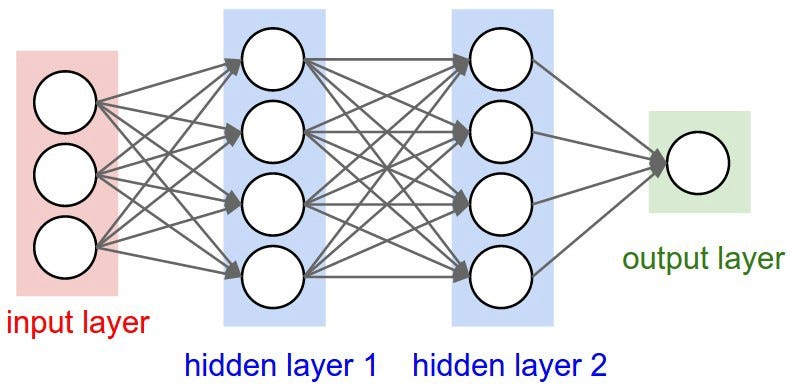

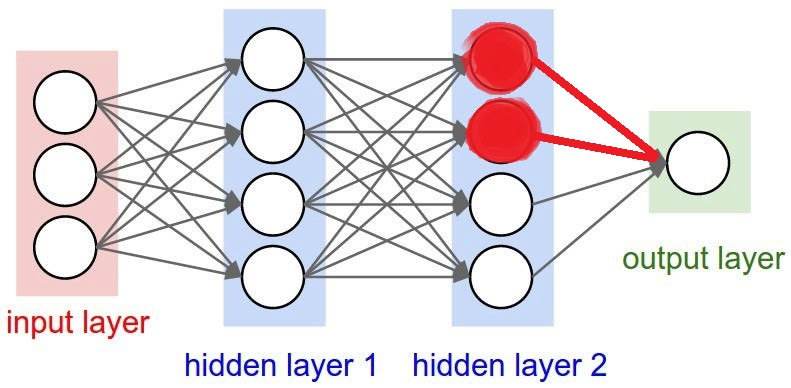

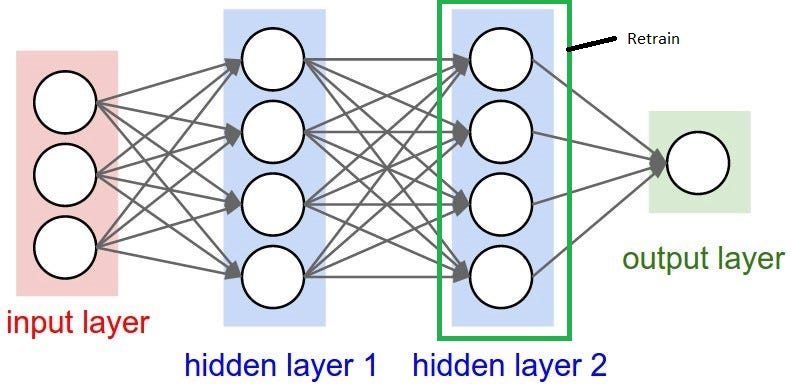

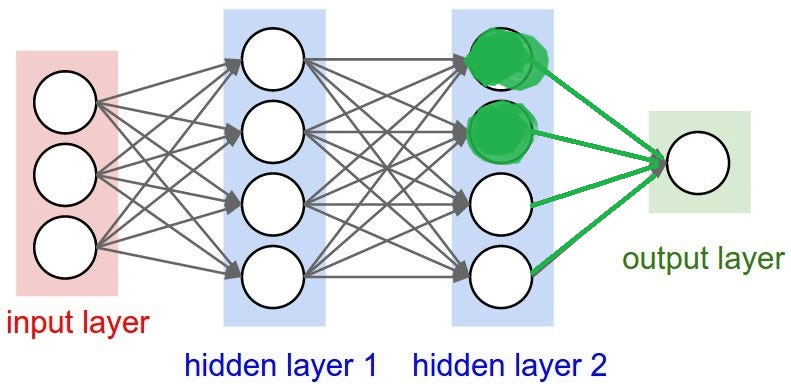

In [4]:
from IPython.display import Image, display

listOfImageNames = ['neural_network.jpg',
                    'neural_network_showing_unfair.jpg',
                   'neural_network_action.jpg',
                   'neural_network_fair.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [32]:
import random
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

def get_paras(net):
    paras=[]
    for name,parameters in net.named_parameters():
        paras.append(parameters)
    return paras

def get_active_neurons4(net,sample):
    neurons=[]
    def hook(module,input,output):
        neurons.append(output.data.detach().clone())
    handle1=net.fc1.register_forward_hook(hook)
    handle2=net.fc2.register_forward_hook(hook)
    handle3=net.fc3.register_forward_hook(hook)
    handle4=net.fc4.register_forward_hook(hook)
    net(x=torch.tensor(sample,dtype=torch.float32))
    handle1.remove()
    handle2.remove()
    handle3.remove()
    handle4.remove()
    return neurons

def get_contrib4(paras,neurons):
    contrib_list=[]
    for i in range(3):
        i=i
        contrib=neurons[i]*paras[2*i+2]
        contrib_list.append(contrib.detach().clone())
    return contrib_list

def get_path_set4(net,sample,GAMMA=0.9):
    active_neuron_indice=[[],[],[],[]]
    path_set=set()
    neurons=get_active_neurons4(net,sample)
    paras=get_paras(net)
    contrib_list=get_contrib4(paras,neurons)
    active_neuron_indice[3].append(torch.argmax(neurons[3]).item())
    for i in range(3):
        L=3-i
        for j in active_neuron_indice[L]:
            s=torch.sort(contrib_list[L-1][j],descending=True)
            sum=0
            for k in range(len(contrib_list[L-1][j])):
                sum+=s.values[k].item()
                active_neuron_indice[L-1].append(s.indices[k].item())
                path_set.add((L,s.indices[k].item(),j))
                if(sum>=GAMMA*neurons[L][j].item()):
                    break
    return path_set



def sample_sort(net, train_dataset, THETA=1e-3, GAMMA=0.9):
    net=net.cpu()
    # THETA = 1e-3
    path_set_list=[]
    for i in (range(len(train_dataset))):
        path_set=get_path_set4(net,train_dataset[i][0],GAMMA=GAMMA)
        path_set_list.append(path_set)
    v=pd.value_counts(path_set_list).rename_axis('pathset').reset_index(name='counts')
#     v_list.append(v)
    t=tuple(v[v.counts<=max(v.counts[0]*THETA,1)].pathset)
    adv_data_idx=[]
    for i in range(len(path_set_list)):
        if path_set_list[i] in t:
            adv_data_idx.append(i)
    print("frac:{}".format(len(adv_data_idx)/len(train_dataset)))
    return adv_data_idx

v_list=[]
def sample_sort_test(net, train_dataset, THETA=1e-3, GAMMA=0.9):
    net=net.cpu()
    # THETA = 1e-3
    path_set_list=[]
    for i in (range(len(train_dataset))):
        path_set=get_path_set4(net,train_dataset[i][0],GAMMA=GAMMA)
        path_set_list.append(path_set)
    v=pd.value_counts(path_set_list).rename_axis('pathset').reset_index(name='counts')
    v_list.append(v)
    t=tuple(v[v.counts<=max(v.counts[0]*THETA,1)].pathset)
    adv_data_idx=[]
    for i in range(len(path_set_list)):
        if path_set_list[i] in t:
            adv_data_idx.append(i)
    print("frac:{}".format(len(adv_data_idx)/len(train_dataset)))
    return adv_data_idx

def get_adv(train_dataset,adv_data_idx,BATCH_SIZE=128):
    x_t_adv, y_t_adv, l_t_adv, s_t_adv = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_adv = a.unsqueeze(0) if x_t_adv is None else torch.cat((x_t_adv,a.unsqueeze(0)),0)
            y_t_adv = b.unsqueeze(0) if y_t_adv is None else torch.cat((y_t_adv,b.unsqueeze(0)),0)
            l_t_adv = c.unsqueeze(0) if l_t_adv is None else torch.cat((l_t_adv,c.unsqueeze(0)),0)
            s_t_adv = d.unsqueeze(0) if s_t_adv is None else torch.cat((s_t_adv,d.unsqueeze(0)),0)
    x_t_benign, y_t_benign, l_t_benign, s_t_benign = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i not in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_benign = a.unsqueeze(0) if x_t_benign is None else torch.cat((x_t_benign,a.unsqueeze(0)),0)
            y_t_benign = b.unsqueeze(0) if y_t_benign is None else torch.cat((y_t_benign,b.unsqueeze(0)),0)
            l_t_benign = c.unsqueeze(0) if l_t_benign is None else torch.cat((l_t_benign,c.unsqueeze(0)),0)
            s_t_benign = d.unsqueeze(0) if s_t_benign is None else torch.cat((s_t_benign,d.unsqueeze(0)),0)

    adv_dataset = TensorDataset(x_t_adv, y_t_adv, l_t_adv, s_t_adv)
    adv_loader = DataLoader(dataset=adv_dataset, batch_size=BATCH_SIZE, shuffle=True)


    benign_dataset = TensorDataset(x_t_benign, y_t_benign, l_t_benign, s_t_benign)
    benign_loader = DataLoader(dataset=benign_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    return adv_loader,benign_loader

def get_adv_rand(train_dataset,adv_data_idx,BATCH_SIZE=128):
    adv_data_idx=random.choices(range(0,len(train_dataset)),k=len(adv_data_idx))
    x_t_adv, y_t_adv, l_t_adv, s_t_adv = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_adv = a.unsqueeze(0) if x_t_adv is None else torch.cat((x_t_adv,a.unsqueeze(0)),0)
            y_t_adv = b.unsqueeze(0) if y_t_adv is None else torch.cat((y_t_adv,b.unsqueeze(0)),0)
            l_t_adv = c.unsqueeze(0) if l_t_adv is None else torch.cat((l_t_adv,c.unsqueeze(0)),0)
            s_t_adv = d.unsqueeze(0) if s_t_adv is None else torch.cat((s_t_adv,d.unsqueeze(0)),0)
    x_t_benign, y_t_benign, l_t_benign, s_t_benign = (None,None,None,None)
    for i in range(len(train_dataset)):
        if i not in adv_data_idx:
            a,b,c,d=train_dataset[i]
            x_t_benign = a.unsqueeze(0) if x_t_benign is None else torch.cat((x_t_benign,a.unsqueeze(0)),0)
            y_t_benign = b.unsqueeze(0) if y_t_benign is None else torch.cat((y_t_benign,b.unsqueeze(0)),0)
            l_t_benign = c.unsqueeze(0) if l_t_benign is None else torch.cat((l_t_benign,c.unsqueeze(0)),0)
            s_t_benign = d.unsqueeze(0) if s_t_benign is None else torch.cat((s_t_benign,d.unsqueeze(0)),0)

    adv_dataset = TensorDataset(x_t_adv, y_t_adv, l_t_adv, s_t_adv)
    benign_dataset = TensorDataset(x_t_benign, y_t_benign, l_t_benign, s_t_benign)

    adv_loader = DataLoader(dataset=adv_dataset, batch_size=BATCH_SIZE, shuffle=True)
    benign_loader = DataLoader(dataset=benign_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return adv_loader,benign_loader

In [33]:
import time
import random
import math
from ray import tune

def Fixate_with_val(net,data_class,epoch=10,dataset='compas',BATCH_SIZE=128):
    def training_function(config):
        # Reading values from config object, setting hyperparameters
        THETA, GAMMA = config['THETA'], config['GAMMA']
        train_dataset_s=config['train_dataset_s']
        val_loader_s=config['val']
        test_loader_s=config['test']
        x_train_tensor_s=config['x_tensor']

        adv_data_idx = sample_sort(net,train_dataset_s,THETA,GAMMA)
        if len(adv_data_idx) == len(train_dataset_s):
            adv_loader = DataLoader(dataset=train_dataset_s, batch_size=BATCH_SIZE, shuffle=True)
            benign_loader = None
        elif len(adv_data_idx) == 0:
            adv_loader = None
            benign_loader = DataLoader(dataset=train_dataset_s, batch_size=BATCH_SIZE, shuffle=True)
        else:
            adv_loader, benign_loader = get_adv(train_dataset_s,adv_data_idx,BATCH_SIZE=BATCH_SIZE)
        net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader_s, test_loader_s, device='cuda', input_shape=x_train_tensor_s.shape[1],
                                                grl_lambda=0,dataset=config['dataset'])
        result = get_metrics(results, data_class.threshold, 0,dataset=config['dataset'])
        
        # !!!!!!!!!!!!!!!!!!!!!!!The unfairness scores are put in a formula !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Calculate complex_score
        complex_score = result['DP']+result['EO']+(1-result['DP ratio'])-0.01*result['acc']
        if math.isnan(complex_score):
            complex_score = result['DP']+result['EO']-0.01*result['acc']
            
        #<------------------------------mean_loss = complex score, so optimizing is done using complex score ---------------->
        tune.report(mean_loss=complex_score)

    our_start=time.time()
    base_size = len(data_class.val_dataset) // 10
    
    # Train, test, validation sizes of split, split again from original validation dataset
    split = [8 * base_size, 1 * base_size, len(data_class.val_dataset) - 9 * base_size]  # Train, validation, test
    #see split below
    train_dataset_s, val_dataset_s, test_dataset_s = random_split(data_class.val_dataset, split)
#     print(train_dataset_s)
    
    val_loader_s = DataLoader(dataset=val_dataset_s, batch_size=BATCH_SIZE)
    test_loader_s = DataLoader(dataset=test_dataset_s, batch_size=BATCH_SIZE)

    x_train_tensor_s = data_class.val_dataset[:][0]

    val_loader = DataLoader(dataset=data_class.val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(dataset=data_class.test_dataset, batch_size=BATCH_SIZE)
    analysis = tune.run(
        training_function,
        config={
            'THETA': tune.grid_search([0.1, 0.01, 3e-3, 1e-3, 3e-4, 1e-4]),
            'GAMMA': tune.grid_search([0.95, 0.9, 0.85, 0.8, 0.7, 0.6]),
            'dataset':dataset,
            'train_dataset_s':train_dataset_s,
            'val':val_loader_s,
            'test':test_loader_s,
            'x_tensor':x_train_tensor_s
        },
        resources_per_trial={
            "cpu": 16,
            "gpu": 2,
        }
    )
    best_config=analysis.get_best_config(metric="mean_loss", mode="min")
    print("Best config: ",best_config)
    THETA = best_config['THETA']
    GAMMA = best_config['GAMMA']
    val_end=time.time()
    for i in range(epoch):
        adv_data_idx = sample_sort(net,data_class.train_dataset,THETA,GAMMA)
        PA_end=time.time()
        adv_loader, benign_loader = get_adv(data_class.train_dataset,adv_data_idx,BATCH_SIZE=BATCH_SIZE)
        SS_end=time.time()
        net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader, test_loader, device='cuda', input_shape=data_class.x_tensor.shape[1],
                                                grl_lambda=0,dataset=dataset)
        Dropout_end=time.time()
        result = get_metrics(results, data_class.threshold, 0, dataset=dataset)
        data_class.global_results.append(result)

    our_end=time.time()
    cost_time=our_end-our_start
    val_time=val_end-our_start
    PA_time=PA_end-val_end
    SS_time=SS_end-PA_end
    Dropout_time=Dropout_end-SS_end
    print('param selection costs:{} s'.format(val_time))
    print('path analysis costs:{} s'.format(PA_time))
    print('sample separation costs:{} s'.format(SS_time))
    print('partial dropout training costs:{} s'.format(Dropout_time))
    print('total time costs:{} s'.format(cost_time))

In [34]:
def Fixate_with_val_rand(net,data_class,epoch=10,dataset='compas',BATCH_SIZE=128):
    def training_function(config):
        THETA, GAMMA = config['THETA'], config['GAMMA']
        train_dataset_s=config['train_dataset_s']
        val_loader_s=config['val']
        test_loader_s=config['test']
        x_train_tensor_s=config['x_tensor']

        adv_data_idx = sample_sort(net,train_dataset_s,THETA,GAMMA)
        if len(adv_data_idx) == len(train_dataset_s):
            benign_loader = None
        else:
            adv_data_idx = random.sample(range(len(train_dataset_s)),len(adv_data_idx))
            adv_loader, benign_loader = get_adv(train_dataset_s,adv_data_idx,BATCH_SIZE=BATCH_SIZE)
        net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader_s, test_loader_s, device='cuda', input_shape=x_train_tensor_s.shape[1],
                                                grl_lambda=0,dataset=config['dataset'])
        result = get_metrics(results, data_class.threshold, 0,dataset=config['dataset'])
        complex_score = result['DP']+result['EO']+(1-result['DP ratio'])-0.01*result['acc']
        tune.report(mean_loss=complex_score)

    our_start=time.time()
    base_size = len(data_class.val_dataset) // 10
    split = [8 * base_size, 1 * base_size, len(data_class.val_dataset) - 9 * base_size]  # Train, validation, test
    train_dataset_s, val_dataset_s, test_dataset_s = random_split(data_class.val_dataset, split)
#     print(train_dataset_s)
    
#     train_loader_s = DataLoader(dataset=train_dataset_s, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_s = DataLoader(dataset=val_dataset_s, batch_size=BATCH_SIZE)
    test_loader_s = DataLoader(dataset=test_dataset_s, batch_size=BATCH_SIZE)

    x_train_tensor_s = data_class.val_dataset[:][0]

    val_loader = DataLoader(dataset=data_class.val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(dataset=data_class.test_dataset, batch_size=BATCH_SIZE)
    analysis = tune.run(
        training_function,
        config={
            'THETA': tune.grid_search([0.1, 0.01, 3e-3, 1e-3, 3e-4, 1e-4]),
            'GAMMA': tune.grid_search([0.95, 0.9, 0.85, 0.8, 0.7, 0.6]),
            'dataset':dataset,
            'train_dataset_s':train_dataset_s,
            'val':val_loader_s,
            'test':test_loader_s,
            'x_tensor':x_train_tensor_s
        },
        resources_per_trial={
            "cpu": 16,
            "gpu": 2,
        }
    )
    best_config=analysis.get_best_config(metric="mean_loss", mode="min")
    print("Best config: ",best_config)
    THETA = best_config['THETA']
    GAMMA = best_config['GAMMA']
    val_end=time.time()
    for i in range(epoch):
        adv_data_idx = sample_sort(net,data_class.train_dataset,THETA,GAMMA)
        PA_end=time.time()
        adv_loader, benign_loader = get_adv(data_class.train_dataset,adv_data_idx,BATCH_SIZE=BATCH_SIZE)
        SS_end=time.time()
        net_drop, results = train_and_evaluate_drop(adv_loader, benign_loader, val_loader, test_loader, device='cuda', input_shape=data_class.x_tensor.shape[1],
                                                grl_lambda=0,dataset=dataset)
        Dropout_end=time.time()
        result = get_metrics(results, data_class.threshold, 0, dataset=dataset)
        data_class.global_results.append(result)

    our_end=time.time()
    cost_time=our_end-our_start
    val_time=val_end-our_start
    PA_time=PA_end-val_end
    SS_time=SS_end-PA_end
    Dropout_time=Dropout_end-SS_end
    print('param selection costs:{} s'.format(val_time))
    print('path analysis costs:{} s'.format(PA_time))
    print('sample separation costs:{} s'.format(SS_time))
    print('partial dropout training costs:{} s'.format(Dropout_time))
    print('total time costs:{} s'.format(cost_time))

In [36]:
rand = 'a'

if rand == '':
    Fixate_with_val_rand(net,data_class,epoch=epoch,BATCH_SIZE=BATCH_SIZE)
else:
    Fixate_with_val(net,data_class,epoch=epoch,BATCH_SIZE=BATCH_SIZE)
res = pd.DataFrame(data_class.global_results)
res
# if not os.path.isdir(outputpath):
#     os.mkdir(outputpath)
# res.to_csv(os.path.join(outputpath,file_name))


2023-03-18 20:24:14,849	INFO worker.py:1553 -- Started a local Ray instance.


C:\Users\Jeroen\anaconda3\envs\fairneuronpaper\lib\site-packages\ray\air\_internal\json.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if np.isnan(value):
C:\Users\Jeroen\anaconda3\envs\fairneuronpaper\lib\site-packages\ray\air\_internal\json.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.isnan(value):


(autoscaler +51s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +51s) Error: No available node types can fulfill resource request {'CPU': 16.0, 'GPU': 2.0}. Add suitable node types to this cluster to resolve this issue.


2023-03-18 20:24:36,026	WARNING tune.py:146 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


KeyboardInterrupt: 